In [1]:
%pip install opendp==0.10.0

Note: you may need to restart the kernel to use updated packages.


In [3]:
import opendp.prelude as dp
dp.enable_features('contrib')

laplace_mechanism = dp.space_of(float) >> dp.m.then_laplace(scale=1.)
dp_value = laplace_mechanism(123.0)
print(dp_value)

122.3554772622428


In [4]:
# call the constructor to produce the measurement `base_lap`
base_lap = dp.m.make_laplace(
    dp.atom_domain(T=float),
    dp.absolute_distance(T=float),
    scale=5.
)

print("input domain:  ", base_lap.input_domain)
print("input metric:  ", base_lap.input_metric)
print("output measure:", base_lap.output_measure)

aggregate = 0.
print("noisy aggregate:", base_lap(aggregate))

absolute_distance = 10.
print("epsilon:", base_lap.map(d_in=absolute_distance))

# call the constructor to produce the transformation `bounded_sum`
# notice that `make_sum` expects an input domain consisting of bounded data:
input_domain = dp.vector_domain(dp.atom_domain(bounds=(0., 5.)))
bounded_sum = dp.t.make_sum(input_domain, dp.symmetric_distance())

# under the condition that the input data is a member of the input domain...
bounded_mock_dataset = [1.3, 3.8, 0., 5.]
# ...the exact sum is:
bounded_sum(bounded_mock_dataset)

# under the condition that one individual may contribute up to 2 records to `bounded_mock_dataset`...
max_contributions = 2
# ...then the sensitivity, expressed in terms of the absolute distance, is:
bounded_sum.map(d_in=max_contributions)

input_domain = dp.vector_domain(dp.atom_domain(T=float))
input_metric = dp.symmetric_distance()

# call the constructor to produce the transformation `clamp`
clamp = dp.t.make_clamp(input_domain, input_metric, bounds=(0., 5.))

# `clamp` expects vectors of non-null, unbounded elements
mock_dataset = [1.3, 7.8, -2.5, 7.0]
# `clamp` emits data that is suitable for `bounded_sum`
clamp(mock_dataset)

# dataset distance in... dataset distance out
clamp.map(max_contributions)

dp_sum = clamp >> bounded_sum >> base_lap

# compute the DP sum of a dataset of bounded elements
print("DP sum:", dp_sum(mock_dataset))

# evaluate the privacy loss of the dp_sum, when an individual can contribute at most 2 records
print("epsilon:", dp_sum.map(d_in=max_contributions))

input domain:   AtomDomain(T=f64)
input metric:   AbsoluteDistance(f64)
output measure: MaxDivergence(f64)
noisy aggregate: 3.9078642542962365
epsilon: 2.0
DP sum: 12.43870015886107
epsilon: 2.000000009313227


In [5]:
# establish public info
max_contributions = 2
bounds = (0., 5.)

# construct the measurement
dp_sum = (
    dp.t.make_clamp(dp.vector_domain(dp.atom_domain(T=float)), dp.symmetric_distance(), bounds) >>
    dp.t.make_sum(dp.vector_domain(dp.atom_domain(bounds=bounds)), dp.symmetric_distance()) >>
    dp.m.make_laplace(dp.atom_domain(T=float), dp.absolute_distance(T=float), 5.)
)

# evaluate the privacy expenditure and make a DP release
mock_dataset = [0.7, -0.3, 1., -1.]
print("epsilon:", dp_sum.map(max_contributions))
print("DP sum release:", dp_sum(mock_dataset))

dp_sum = (
    (input_domain, input_metric) >>
    dp.t.then_clamp((0., 5.)) >>
    dp.t.then_sum() >>
    dp.m.then_laplace(5.)
)

epsilon: 2.000000009313227
DP sum release: 2.555396654326963


# Typical Workflow !!

## Context

In [3]:
import opendp.prelude as dp
dp.enable_features("contrib")

# Identify the Unit of Privacy
privacy_unit = dp.unit_of(contributions=1)
# input_metric, d_in = privacy_unit

# Set Privacy Loss Parameters
privacy_loss = dp.loss_of(epsilon=1.)
# privacy_measure, d_out = privacy_loss

# Collect Public Information
col_names = [
   "name", "sex", "age", "maritalStatus", "hasChildren", "highestEducationLevel", 
   "sourceOfStress", "smoker", "optimism", "lifeSatisfaction", "selfEsteem"
]

# Mediate Access to Data
import urllib.request

data_url = "https://raw.githubusercontent.com/opendp/opendp/sydney/teacher_survey.csv"
with urllib.request.urlopen(data_url) as data_req:
    data = data_req.read().decode('utf-8')

context = dp.Context.compositor(
    data=data,
    privacy_unit=privacy_unit,
    privacy_loss=privacy_loss,
    split_evenly_over=3
)

# Submit DP Queries

## Count
count_query = (
    context.query()
    .split_dataframe(",", col_names=col_names)
    .select_column("age", str) # temporary until OpenDP 0.10 (Polars dataframe)
    .count()
    .laplace()
)

scale = count_query.param()
print(scale)

accuracy = dp.discrete_laplacian_scale_to_accuracy(scale=scale, alpha=0.05)
print(accuracy)

dp_count = count_query.release()
interval = (dp_count - accuracy, dp_count + accuracy)

## Mean
mean_query = (
    context.query()
    .split_dataframe(",", col_names=col_names)
    .select_column("age", str)
    .cast_default(float)
    .clamp((18.0, 70.0))  # a best-guess based on public information
    # Explanation for `constant=42`:
    #    since dp_count may be larger than the true size, 
    #    imputed rows will be given an age of 42.0 
    #    (also a best guess based on public information)
    .resize(size=dp_count, constant=42.0)
    .mean()
    .laplace()
)

dp_mean = mean_query.release()

3.0000000000000004
9.445721638273584


## Framework API !

In [ ]:
import opendp.prelude as dp
dp.enable_features("contrib")

# Identify the Unit of Privacy
d_in = 1 # neighboring data set distance is at most d_in...
input_metric = dp.symmetric_distance() # ...in terms of additions/removals

# Set Privacy Loss Parameters
d_out = 1. # output distributions have distance at most d_out (ε)...
privacy_measure = dp.max_divergence(T=float) # ...in terms of pure-DP

# Collect Public Information
col_names = [
   "name", "sex", "age", "maritalStatus", "hasChildren", "highestEducationLevel", 
   "sourceOfStress", "smoker", "optimism", "lifeSatisfaction", "selfEsteem"
]

# Mediate Access to Data
import urllib.request

data_url = "https://raw.githubusercontent.com/opendp/opendp/sydney/teacher_survey.csv"
with urllib.request.urlopen(data_url) as data_req:
    data = data_req.read().decode('utf-8')

m_sc = dp.c.make_sequential_composition(
    # data set is a single string, with rows separated by linebreaks
    input_domain=dp.atom_domain(T=str),
    input_metric=input_metric,
    output_measure=privacy_measure,
    d_in=d_in,
    d_mids=[d_out / 3] * 3,
)

# Call measurement with data to create a queryable:
qbl_sc = m_sc(data)

count_transformation = (
    dp.t.make_split_dataframe(",", col_names=col_names)
    >> dp.t.make_select_column("age", str)
    >> dp.t.then_count()
)

count_sensitivity = count_transformation.map(d_in)
count_sensitivity

count_measurement = dp.binary_search_chain(
    lambda scale: count_transformation >> dp.m.then_laplace(scale), 
    d_in, d_out / 3
)

dp_count = qbl_sc(count_measurement)

mean_transformation = (
    dp.t.make_split_dataframe(",", col_names=col_names) >>
    dp.t.make_select_column("age", str) >>
    dp.t.then_cast_default(float) >>
    dp.t.then_clamp((18.0, 70.0)) >>  # a best-guess based on public information
    dp.t.then_resize(size=dp_count, constant=42.0) >>
    dp.t.then_mean()
)

mean_measurement = dp.binary_search_chain(
    lambda scale: mean_transformation >> dp.m.then_laplace(scale), 
    d_in, d_out / 3
)

dp_mean = qbl_sc(mean_measurement)

# More examples

## Data analysis

### Context 

In [ ]:
import opendp.prelude as dp
dp.enable_features("contrib")

# the greatest number of records that any one individual can influence in the dataset
privacy_unit = dp.unit_of(contributions=1)

# Set Privacy Loss Parameters
privacy_loss = dp.loss_of(epsilon=1.)

# establish public information
col_names = ["age", "sex", "educ", "race", "income", "married"]
# we can also reasonably intuit that age and income will be numeric,
#     as well as bounds for them, without looking at the data
age_bounds = (0, 100)
income_bounds = (0, 150_000)

![ -e data.csv ] || wget https://raw.githubusercontent.com/opendp/opendp/main/docs/source/data/PUMS_california_demographics_1000/data.csv

with open('data.csv') as input_file:
    data = input_file.read()

context = dp.Context.compositor(
    data=data,
    privacy_unit=privacy_unit,
    privacy_loss=privacy_loss,
    split_evenly_over=5
)

# estimate the budget...
epsilon = dp.binary_search(
    lambda eps: dp_count.check(d_in=max_influence, d_out=eps),
    bounds=(0., 100.))
print("DP count budget:", epsilon)

# ...and then release
count_release = dp_count(data)
print("DP count:", count_release)

# Submit DP Queries

## Count
count_query = (
    context.query()
    .split_dataframe(",", col_names=col_names)
    .select_column("income", str)
    .cast_default(int)
    .imput_constant(0)
    .count()
    .laplace()#scale =1.
)

scale = count_query.param()
print(scale)

accuracy = dp.discrete_laplacian_scale_to_accuracy(scale=scale, alpha=0.05)
print(accuracy)

dp_count = count_query.release()
interval = (dp_count - accuracy, dp_count + accuracy)

# Private Sum
sum_query = (
    context.query()
    .split_dataframe(",", col_names=col_names)
    .select_column("income", str)
    .cast_default(int)
    .imput_constant(0)
    .clamp(income_bounds)
    .sum()
    #.laplace()
)

discovered_scale = dp.binary_search_param(
    lambda s: bounded_income_sum >> dp.m.then_laplace(scale=s),
    d_in=max_influence,
    d_out=1.)

dp_sum = bounded_income_sum >> dp.m.then_laplace(scale=discovered_scale)

dp_sum = dp.binary_search_chain(
    lambda s: bounded_income_sum >> dp.m.then_laplace(scale=s),
    d_in=max_influence,
    d_out=1.)

# ...and make our 1-epsilon DP release
print("DP sum:", dp_sum(data))

## Mean
float_age_bounds = tuple(map(float, age_bounds))

mean_query = (
    context.query()
    .split_dataframe(",", col_names=col_names)
    .select_column("age", str)
    .cast_default(float)
    .clamp(float_age_bounds)  # a best-guess based on public information
    # Explanation for `constant=42`:
    #    since dp_count may be larger than the true size, 
    #    imputed rows will be given an age of 42.0 
    #    (also a best guess based on public information)
    .resize(size=dp_count, constant=20.0)
    .mean()
    .laplace() # 1.0
)

dp_mean = mean_query.release()

### Framework

In [ ]:
import opendp.prelude as dp
dp.enable_features('contrib')

# the greatest number of records that any one individual can influence in the dataset
max_influence = 1

# establish public information
col_names = ["age", "sex", "educ", "race", "income", "married"]
# we can also reasonably intuit that age and income will be numeric,
#     as well as bounds for them, without looking at the data
age_bounds = (0, 100)
income_bounds = (0, 150_000)

# Working with CSV data
income_preprocessor = (
    # Convert data into a dataframe where columns are of type Vec<str>
    dp.t.make_split_dataframe(separator=",", col_names=col_names) >>
    # Selects a column of df, Vec<str>
    dp.t.make_select_column(key="income", TOA=str)
)

![ -e data.csv ] || wget https://raw.githubusercontent.com/opendp/opendp/main/docs/source/data/PUMS_california_demographics_1000/data.csv

with open('data.csv') as input_file:
    data = input_file.read()

# As we can see from the first few rows, it is intentional that there are no column names in the data. 
# If your data has column names, you will want to strip them out before passing data into your function
print('\n'.join(data.split('\n')[:6]))

transformed = income_preprocessor(data)
print(type(transformed))
print(transformed[:6])

59,1,9,1,0,1
31,0,1,3,17000,0
36,1,11,1,0,1
54,1,11,1,9100,1
39,0,5,3,37000,0
34,0,9,1,0,1
<class 'list'>
['0', '17000', '0', '9100', '37000', '0']


In [ ]:
# Casting
# make a transformation that casts from a vector of strings to a vector of ints
cast_str_int = (
    # start with the output space of the income_preprocessor
    income_preprocessor.output_space >>
    # cast Vec<str> to Vec<Option<int>>
    dp.t.then_cast(TOA=int) >>
    # Replace any elements that failed to parse with 0, emitting a Vec<int>
    dp.t.then_impute_constant(0)
)

# replace the previous preprocessor: extend it with the caster
income_preprocessor = income_preprocessor >> cast_str_int
print(income_preprocessor(data)[:6])

cast_str_int(["null", "1.", "2"])

[0, 17000, 0, 9100, 37000, 0]


[0, 0, 2]

In [ ]:
# Private Count
dp_count = (
    income_preprocessor >> 
    dp.t.then_count() >> 
    dp.m.then_laplace(scale=1.) # Ici on fixe un scale à 1 et on estime le budget auquel ça revient
)

# estimate the budget...
epsilon = dp.binary_search(
    lambda eps: dp_count.check(d_in=max_influence, d_out=eps),
    bounds=(0., 100.))
print("DP count budget:", epsilon)

# ...and then release
count_release = dp_count(data)
print("DP count:", count_release)

DP count budget: 1.0
DP count: 1000


In [ ]:
# Private Sum
bounded_income_sum = (
    income_preprocessor >>
    # clamp income values.
    # "then_*" means it uses the output domain and output metric from the previous transformation
    dp.t.then_clamp(bounds=income_bounds) >>
    # similarly, here we use "then_sum" to avoid needing to specify the input space.
    # the sum constructor gets told that the input consists of bounded data
    dp.t.then_sum()
)

discovered_scale = dp.binary_search_param(
    lambda s: bounded_income_sum >> dp.m.then_laplace(scale=s),
    d_in=max_influence,
    d_out=1.) # Ici on cherche le scale de sorte que ca soit 1-DP

dp_sum = bounded_income_sum >> dp.m.then_laplace(scale=discovered_scale)

# OU de manière raccourci

dp_sum = dp.binary_search_chain(
    lambda s: bounded_income_sum >> dp.m.then_laplace(scale=s),
    d_in=max_influence,
    d_out=1.)

# ...and make our 1-epsilon DP release
print("DP sum:", dp_sum(data))

DP sum: 30368227


In [12]:
# Private Mean
try:
    mean_age_preprocessor = (
        # Convert data into a dataframe of string columns
        dp.t.make_split_dataframe(separator=",", col_names=col_names) >>
        # Selects a column of df, Vec<str>
        dp.t.make_select_column(key="age", TOA=str) >>
        # Cast the column as Vec<float>, and fill nulls with the default value, 0.
        dp.t.then_cast_default(TOA=float) >>
        # Clamp age values
        dp.t.then_clamp(bounds=age_bounds)
    )
except TypeError as err:
    assert str(err).startswith("inferred type is") # type: ignore
    print(err)

float_age_bounds = tuple(map(float, age_bounds))

dp_mean = (
    # Convert data into a dataframe of string columns
    dp.t.make_split_dataframe(separator=",", col_names=col_names) >>
    # Selects a column of df, Vec<str>
    dp.t.make_select_column(key="age", TOA=str) >>
    # Cast the column as Vec<float>, and fill nulls with the default value, 0.
    dp.t.then_cast_default(TOA=float) >>
    # Clamp age values
    dp.t.then_clamp(bounds=float_age_bounds) >>
    # Resize the dataset to length `count_release`.
    #     If there are fewer than `count_release` rows in the data, fill with a constant of 20.
    #     If there are more than `count_release` rows in the data, only keep `count_release` rows
    dp.t.then_resize(size=count_release, constant=20.) >>
    # Compute the mean
    dp.t.then_mean() >>
    # add laplace noise
    dp.m.then_laplace(scale=1.0)
)

mean_release = dp_mean(data)
print("DP mean:", mean_release)

inferred type is i32, expected f64. See https://github.com/opendp/opendp/discussions/298
DP mean: 45.94604350360122


In [ ]:
# Zero-Concentrated Differential Privacy
variance = (
    # Convert data into a dataframe of string columns
    dp.t.make_split_dataframe(separator=",", col_names=col_names) >>
    # Selects a column of df, Vec<str>
    dp.t.make_select_column(key="age", TOA=str) >>
    # Cast the column as Vec<float>, and fill nulls with the default value, 0.
    dp.t.then_cast_default(TOA=float) >>
    # Clamp age values
    dp.t.then_clamp(bounds=float_age_bounds) >>
    # Resize the dataset to length `count_release`.
    dp.t.then_resize(size=count_release, constant=20.) >>
    # Compute the variance
    dp.t.then_variance()
)

dp_variance = dp.binary_search_chain(
    lambda s: variance >> dp.m.then_gaussian(scale=s),
    d_in=max_influence, d_out=.05) # Il comprend qu'on est en zCDP

print("DP variance:", dp_variance(data))

DP variance: 310.6186108219521


In [ ]:
# Measure Casting
app_dp_variance = dp.c.make_zCDP_to_approxDP(dp_variance)
# evaluate the privacy map to get a curve
curve = app_dp_variance.map(max_influence)
# solve for epsilon when delta is fixed
print(curve.epsilon(delta=1e-7))

# OUdpdddezzz
fixed_app_dp_variance = dp.c.make_fix_delta(app_dp_variance, delta=1e-7)
print(fixed_app_dp_variance.map(max_influence))

# Si on veut directement trouver le scale selon le (epsilon, delta) budget
budget = (1., 1e-7)
def make_dp_variance(scale):
    dp_var = variance >> dp.m.then_gaussian(scale)
    return dp.c.make_fix_delta(dp.c.make_zCDP_to_approxDP(dp_var), delta=budget[1])

dp_variance_lte_budget = dp.binary_search_chain(
    make_dp_variance,
    d_in=max_influence, d_out=budget)

# we know this measurement is calibrated to be lte budget
assert dp_variance_lte_budget.check(max_influence, budget)

1.6194085342284823
(1.6194085342284823, 1e-07)


In [25]:
# Composition
composed = dp.c.make_basic_composition([dp_sum, dp_mean])
print(composed(data))

print("Budget used :", composed.map(max_influence))

[30203275, 45.04232653562927]
Budget used : 1.1000000000004568


## Unknown dataset sizes

### Framework

In [ ]:
![ -e data.csv ] || wget https://raw.githubusercontent.com/opendp/opendp/main/docs/source/data/PUMS_california_demographics_1000/data.csv

# Define parameters up-front
# Each parameter is either a guess, a DP release, or public information
var_names = ["age", "sex", "educ", "race", "income", "married"] # public information
age_bounds = (0., 120.) # an educated guess
age_prior = 38. # average age for entire US population (public information)
size = 1000 # records in dataset, public information

# Load data
import numpy as np
age = np.genfromtxt('data.csv', delimiter=',', names=var_names)[:]['age'].tolist() # type: ignore

In [28]:
# Dataset size known
dp.enable_features("contrib", "floating-point")

input_domain = dp.vector_domain(dp.atom_domain(T=float), size=1000)
input_metric = dp.symmetric_distance()

dp_mean = (
    (input_domain, input_metric) >>
    # Clamp age values
    dp.t.then_clamp(bounds=age_bounds) >>
    # Aggregate
    dp.t.then_mean() >>
    # Noise
    dp.m.then_laplace(scale=1.)
)

print("DP mean:", dp_mean(age))

DP mean: 43.00335629387776


In [30]:
# If unknown
# First, estimate the number of records in the dataset.
dp_count = (input_domain, input_metric) >> dp.t.then_count() >> dp.m.then_laplace(scale=1.)
dp_count_release = dp_count(age)
print("DP count: {0}".format(dp_count_release))

DP count: 1001


In [31]:
def make_mean_measurement(target_size):
    """a convenience constructor for building a mean measurement that resizes to `target_size`"""
    return ((dp.vector_domain(dp.atom_domain(T=float)), dp.symmetric_distance()) >>
            dp.t.then_resize(size=target_size, constant=age_prior) >>
            dp.t.then_clamp(age_bounds) >>
            dp.t.then_mean() >>
            dp.m.then_laplace(scale=1.0))


dp_mean = make_mean_measurement(dp_count_release)
dp_mean_release = dp_mean(age)
print("DP mean: {0}".format(dp_mean_release))

DP mean: 43.50071057005583


In [39]:
lower_n = make_mean_measurement(target_size=200)(age)
real_n = make_mean_measurement(target_size=1000)(age)
higher_n = make_mean_measurement(target_size=2000)(age)

print("DP mean (n=200):  {0}".format(lower_n))
print("DP mean (n=1000): {0}".format(real_n))
print("DP mean (n=2000): {0}".format(higher_n))

DP mean (n=200):  43.63174276237886
DP mean (n=1000): 46.516263634001746
DP mean (n=2000): 45.142882779866895


In [ ]:
from functools import lru_cache

input_space = dp.vector_domain(dp.atom_domain(T=float)), input_metric

@lru_cache(maxsize=None)
def make_count_with(*, epsilon):
    counter = input_space >> dp.t.then_count()
    return dp.binary_search_chain(
        lambda s: counter >> dp.m.then_laplace(scale=s),
        d_in=1, d_out=epsilon,
        bounds=(0., 10000.))

@lru_cache(maxsize=None)
def make_mean_with(*, target_size, epsilon):
    mean_chain = (
        input_space >>
        # Resize the dataset to length `target_size`.
        #     If there are fewer than `target_size` rows in the data, fill with a constant.
        #     If there are more than `target_size` rows in the data, only keep `data_size` rows
        dp.t.then_resize(size=target_size, constant=age_prior) >>
        # Clamp age values
        dp.t.then_clamp(bounds=age_bounds) >>
        # Compute the mean
        dp.t.then_mean()
    )
    return dp.binary_search_chain(
        lambda s: mean_chain >> dp.m.then_laplace(scale=s),
        d_in=1, d_out=epsilon,
        bounds=(0., 10.))

@lru_cache(maxsize=None)
def make_sum_with(*, epsilon):
    bounded_age_sum = (
        input_space >>
        # Clamp income values
        dp.t.then_clamp(bounds=age_bounds) >>
        dp.t.then_sum()
    )
    return dp.binary_search_chain(
        lambda s: bounded_age_sum >> dp.m.then_laplace(scale=s),
        d_in=1, d_out=epsilon,
        bounds=(0., 1000.))

In [52]:
n_simulations = 1000

history_count = []
history_mean = []

print("Status:")
for i in range(n_simulations):
    if i % 100 == 0:
        print(f"{i / n_simulations:.0%} ", end="")

    count_chain = make_count_with(epsilon=0.05)
    history_count.append(count_chain(age))

    mean_chain = make_mean_with(target_size=history_count[-1], epsilon=1.)
    history_mean.append(mean_chain(age))

print("100%")

Status:
0% 10% 20% 30% 40% 50% 60% 70% 80% 90% 100%


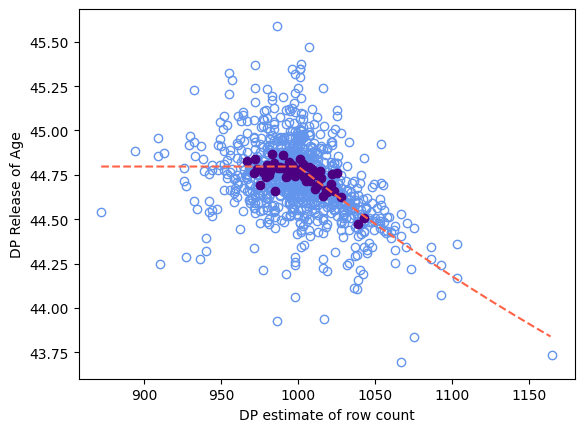

In [53]:
import matplotlib.pyplot as plt
import statistics

true_mean_age = statistics.mean(age)

# The light blue circles are DP means
plt.plot(history_count, history_mean, 'o', fillstyle='none', color = 'cornflowerblue')

def compute_expected_mean(count):
    count = max(count, size)
    return ((true_mean_age * size) + (count - size) * age_prior) / count

expected_count = list(range(min(history_count), max(history_count)))
expected_mean = list(map(compute_expected_mean, expected_count))

# The dark blue dots are the average DP mean per dataset size
for count in expected_count:
    sims = [m for c, m in zip(history_count, history_mean) if c == count]
    if len(sims) > 6:
        plt.plot(count, statistics.mean(sims), 'o', color = 'indigo')

# The red line is the expected value by dp release of dataset size
plt.plot(expected_count, expected_mean, linestyle='--', color = 'tomato')
plt.ylabel('DP Release of Age')
plt.xlabel('DP estimate of row count')
plt.show()

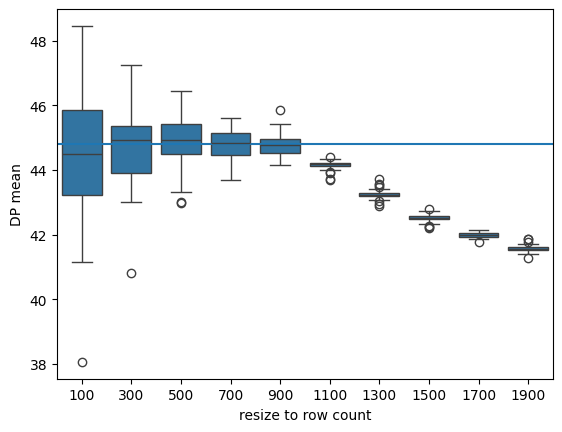

In [44]:
import pandas as pd
import seaborn as sns

releases = []
# X axis ticks
n_range = range(100, 2001, 200)
# Number of samples per boxplot
n_simulations = 50

for n in n_range:
    mean_chain = make_mean_with(target_size=n, epsilon=1.)
    for index in range(n_simulations):

        # get mean of age at the given n
        releases.append((n, mean_chain(age)))

# get released values
df = pd.DataFrame.from_records(releases, columns=['resize to row count', 'DP mean'])

# The boxplots show the distribution of releases per n
plot = sns.boxplot(x = 'resize to row count', y = 'DP mean', data = df)
# The blue line is the true mean
plot.axhline(true_mean_age)
plt.show()

In [45]:
n_simulations = 1_000
history_plugin = []
history_resize = []

# sized estimators are more robust to noisy counts, so epsilon is small
# the less epsilon provided to this count, the more the result will be biased towards the prior
resize_count = make_count_with(epsilon=0.2)

# plugin estimators want a much more accurate count
plugin_count = make_count_with(epsilon=0.5)
plugin_sum = make_sum_with(epsilon=0.5)

print("Status:")
for i in range(n_simulations):
    if i % 100 == 0:
        print(f"{i / n_simulations:.0%} ", end="")

    history_plugin.append(plugin_sum(age) / plugin_count(age))

    resize_mean = make_mean_with(target_size=resize_count(age), epsilon=.8)
    history_resize.append(resize_mean(age))

print('100%')

Status:
0% 10% 20% 30% 40% 50% 60% 70% 80% 90% 100%


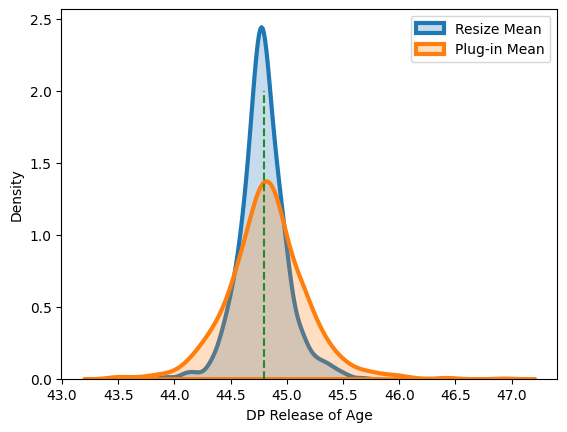

In [46]:
fig, ax = plt.subplots()
sns.kdeplot(history_resize, fill=True, linewidth=3,
                 label = 'Resize Mean')
sns.kdeplot(history_plugin, fill=True, linewidth=3,
                 label = 'Plug-in Mean')

ax.plot([true_mean_age,true_mean_age], [0,2], linestyle='--', color = 'forestgreen')
plt.xlabel('DP Release of Age')
leg = ax.legend()

# Privatizing histograms

In [55]:
![ -e data.csv ] || wget https://raw.githubusercontent.com/opendp/opendp/main/docs/source/data/PUMS_california_demographics_1000/data.csv

import opendp.prelude as dp
dp.enable_features("contrib", "floating-point")
max_influence = 1
budget = (1., 1e-8)

# public information
col_names = ["age", "sex", "educ", "race", "income", "married"]
size = 1000

with open('data.csv') as input_data:
    data = input_data.read()

def plot_histogram(sensitive_counts, released_counts):
    """Plot a histogram that compares true data against released data"""
    import matplotlib.pyplot as plt
    import matplotlib.ticker as ticker

    fig = plt.figure()
    ax = fig.add_axes([1,1,1,1])
    plt.ylim([0,225])
    tick_spacing = 1.
    ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
    plt.xlim(0,15)
    width = .4

    ax.bar(list([x+width for x in range(0, len(sensitive_counts))]), sensitive_counts, width=width, label='True Value')
    ax.bar(list([x+2*width for x in range(0, len(released_counts))]), released_counts, width=width, label='DP Value')
    ax.legend()
    plt.title('Histogram of Education Level')
    plt.xlabel('Years of Education')
    plt.ylabel('Count')
    plt.show()

Educational level counts:
 [33, 14, 38, 17, 24, 21, 31, 51, 201, 60, 165, 76, 178, 54, 24, 13, 0, 0, 0]
DP Educational level counts:
 [34, 13, 39, 17, 24, 22, 32, 50, 204, 60, 161, 77, 180, 54, 24, 12, 0, 0, 1]
DP estimate for the number of records that were not a member of the category set: -1


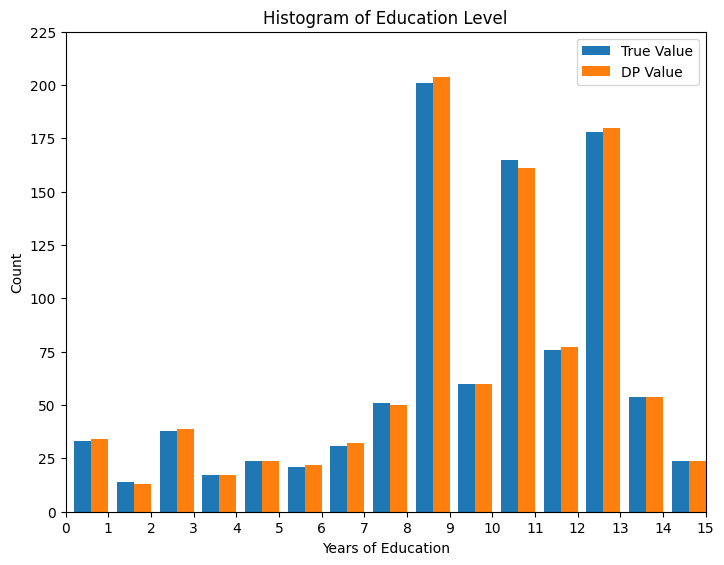

In [56]:
# public information
categories = list(map(str, range(1, 20)))

histogram = (
    dp.t.make_split_dataframe(separator=",", col_names=col_names) >>
    dp.t.make_select_column(key="educ", TOA=str) >>
    # Compute counts for each of the categories and null
    dp.t.then_count_by_categories(categories=categories)
)

noisy_histogram = dp.binary_search_chain(
    lambda s: histogram >> dp.m.then_laplace(scale=s),
    d_in=max_influence, d_out=budget[0])

sensitive_counts = histogram(data)
released_counts = noisy_histogram(data)

print("Educational level counts:\n", sensitive_counts[:-1])
print("DP Educational level counts:\n", released_counts[:-1])

print("DP estimate for the number of records that were not a member of the category set:", released_counts[-1])

plot_histogram(sensitive_counts, released_counts)

In [57]:
def make_laplace_threshold_budget(
    preprocess: dp.Transformation,
    d_in, d_out
) -> dp.Measurement:
    """Make a stability histogram that respects a given d_in, d_out."""
    def privatize(s, t=1e8):
        return preprocess >> dp.m.then_laplace_threshold(scale=s, threshold=t)

    s = dp.binary_search_param(lambda s: privatize(s=s), d_in, d_out)
    t = dp.binary_search_param(lambda t: privatize(s=s, t=t), d_in, d_out)

    return privatize(s=s, t=t)

Educational level counts:
 [33, 14, 38, 17, 24, 21, 31, 51, 201, 60, 165, 76, 178, 54, 24, 13, 0, 0, 0, 0]
DP Educational level counts:
 {'12': 76, '8': 52, '11': 166, '14': 54, '15': 25, '7': 32, '10': 63, '9': 201, '5': 25, '3': 36, '6': 20, '1': 35, '13': 180}


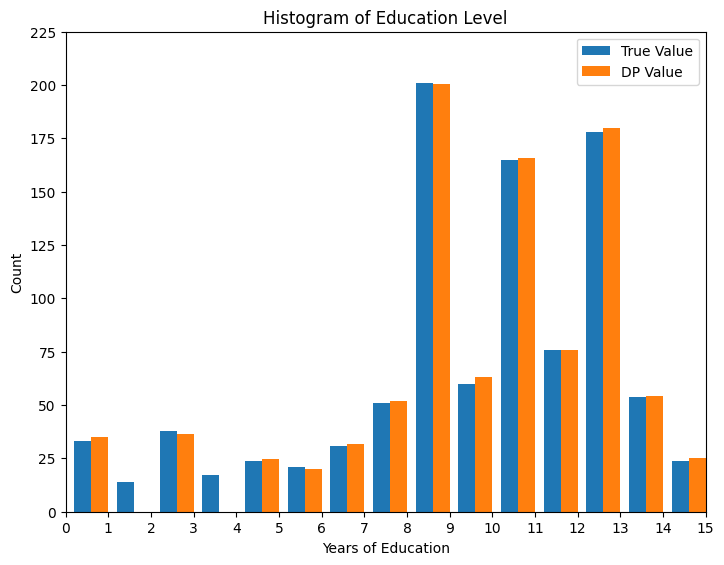

In [58]:
preprocess = (
    dp.t.make_split_dataframe(separator=",", col_names=col_names) >>
    dp.t.make_select_column(key="educ", TOA=str) >>
    dp.t.then_count_by(MO=dp.L1Distance[float], TV=float)
)

noisy_histogram = make_laplace_threshold_budget(
    preprocess,
    d_in=max_influence, d_out=budget)

sensitive_counts = histogram(data)
released_counts = noisy_histogram(data)
# postprocess to make the results easier to compare
postprocessed_counts = {k: round(v) for k, v in released_counts.items()}

print("Educational level counts:\n", sensitive_counts)
print("DP Educational level counts:\n", postprocessed_counts)

def as_array(data):
    return [data.get(k, 0) for k in categories]

plot_histogram(sensitive_counts, as_array(released_counts))

# Video

In [ ]:
import numpy as np
dp.enable_features("honest-but-curious")

def make_sum(bounds):
    L, U = bounds
    return dp.t.make_user_transformation(
        input_domain = dp.vector_domain(dp.atom_domain(bounds=bounds)),
        input_metric = dp.symmetric_distance(),
        output_domain = dp.atom_domain(T=int),
        output_metric= dp.absolute_distance(T=int),
        function=sum,
        stability_map= lambda d_in: d_in * max(abs(L), U)
    )

def make_laplace(scale):
    L, U = bounds
    return dp.m.make_user_measurement(
        input_domain = dp.atom_domain(T=int),
        input_metric = dp.absolute_distance(T=int),
        output_measure = dp.max_divergence(T=int),
        function=lambda x: np.random.laplace(loc=x, scale=scale),
        privacy_map= lambda d_in: d_in / scale
    )

m_sum = make_sum((0, 1))

m_lap = make_laplace(scale=1.)
m_lap(10)
m_sum([1,4,5])

# Test polars

In [ ]:
%pip install 'opendp[polars]'

In [119]:
import urllib.request
import polars as pl
import opendp.prelude as dp

dp.enable_features("contrib")

lf_domain = dp.lazyframe_domain([
    dp.series_domain("grade", dp.atom_domain(T=int)),
    dp.series_domain("pet_count", dp.atom_domain(T=int))])

lf_domain_with_margin = dp.with_margin(
    lf_domain,
    by=["grade"],
    public_info="keys",
    max_partition_length=50)

plan = (
    pl.LazyFrame(schema={'grade': pl.Int32, 'pet_count': pl.Int32})
    .group_by("grade")
    .agg(pl.col("pet_count").dp.sum((0, 10), scale=1.0))
    .sort("grade"))

dp_sum_pets_by_grade = dp.m.make_private_lazyframe(
    input_domain=lf_domain_with_margin,
    input_metric=dp.symmetric_distance(),
    output_measure=dp.max_divergence(T=float),
    lazyframe=plan,
    global_scale=1.0)

df = pl.from_records(
    [
        [0, 0], # No kindergarteners with pets.
        [0, 0],
        [0, 0],
        [1, 1], # Each first grader has 1 pet.
        [1, 1],
        [1, 1],
        [2, 1], # One second grader has chickens!
        [2, 1],
        [2, 9]
    ],

    schema=['grade', 'pet_count'])

lf = pl.LazyFrame(df)

results = dp_sum_pets_by_grade(lf).collect()

print(results) 

shape: (3, 2)
┌───────┬───────────┐
│ grade ┆ pet_count │
│ ---   ┆ ---       │
│ i64   ┆ i64       │
╞═══════╪═══════════╡
│ 0     ┆ 1         │
│ 1     ┆ 2         │
│ 2     ┆ 11        │
└───────┴───────────┘


In [ ]:
import urllib.request
import polars as pl
import opendp.prelude as dp

dp.enable_features("contrib")

context = dp.Context.compositor(
    data=pl.LazyFrame({"age": list(range(100))}),
    privacy_unit=dp.unit_of(contributions=1),
    privacy_loss=dp.loss_of(epsilon=100.),
    split_evenly_over=3,
    margins={(): dp.Margin(max_partition_length=100),
    ("age"): dp.Margin(max_partition_length=100)}
)

candidates = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90]

query = context.query().select(
    pl.len().dp.laplace(),
    *[pl.col("age").fill_null(0).dp.quantile(a, candidates).alias(f"{a}-Quantile") for a in [0.25, 0.5, 0.75]],
    pl.col.age.fill_null(35).dp.sum(bounds=(0, 100)).alias("somme")
)

query.release().collect()
query.release().collect().with_columns(mean=pl.col.somme / pl.col.len)
#query = context.query().select(pl.col("age").fill_null(0).dp.mean((0, 100)))

epsilon should be less than or equal to 5, and is typically less than or equal to 1


len,0.25-Quantile,0.5-Quantile,0.75-Quantile,somme,mean
u32,i64,i64,i64,i64,f64
98,30,50,70,4950,50.510204
